# Analyis of Results from Llama3.2 Evaluation on SQuAD

## 0. Imports

In [1]:
import json
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [2]:
results_file = 'results.json'

## 1. Parsing Results 

The result of the evaluation is passed and exact match is accouted for. This refers to an exact word to word match. However, this is not representative of the results since several words from the LLM can be counted as deceptive. 
<br/> Example of such answer:<br/>
```json
"What is an example of an NP-intermediate problem not known to exist in P or NP-complete? ": {
    "ground_truth": "graph isomorphism problem",
    "llm_answer": "The graph isomorphism problem",
    "rouge_score": {
      "precision": 0.75,
      "recall": 1.0,
      "fmeasure": 0.8571428571428571
    }
```
As can be seen "The" word can cause the exact match to fail and this will be counted as an incorrect match. Therefore, f-measure which is a more consistent metric will be used for actual visualization of the results

In [3]:
with open(results_file, 'r') as f:
    results = json.load(f)

In [4]:
# Parse Data
total_questions = len(results)
exact_correct_answers = 0
precision_scores = []
recall_scores = []
fmeasure_scores = []

for question, data in results.items():
    # Calculate exact match accuracy
    if data["llm_answer"] == data["ground_truth"]:
        exact_correct_answers += 1

    rouge = data["rouge_score"]
    precision_scores.append(rouge["precision"])
    recall_scores.append(rouge["recall"])
    fmeasure_scores.append(rouge["fmeasure"])

accuracy = exact_correct_answers / total_questions
avg_precision = sum(precision_scores) / total_questions
avg_recall = sum(recall_scores) / total_questions
avg_fmeasure = sum(fmeasure_scores) / total_questions

In [5]:
# Calculate accuracy with F1 score
accuracy_f1 = sum(1 for score in fmeasure_scores if score > 0.5)

In [6]:
print(f"The accuracy of Llama3.2 based on the Fmeasure: {accuracy_f1}")
print(f"The accuracy of Llama3.2 based on the exact answer match: {exact_correct_answers}")

The accuracy of Llama3.2 based on the Fmeasure: 4552
The accuracy of Llama3.2 based on the exact answer match: 2193


## 3. Pie Charts

### 3.1 Exact Answer Match

In this case, there are more incorrect answers compared to correct ones.

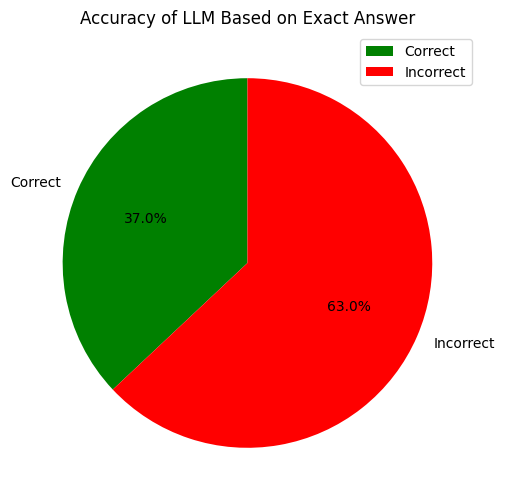

In [7]:
#Pie Chart for Exact Answer Accuracy
labels = ["Correct", "Incorrect"]
sizes = [exact_correct_answers, total_questions - exact_correct_answers]
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90, colors=["green", "red"])
plt.legend()
plt.title("Accuracy of LLM Based on Exact Answer")
plt.show()

### 3.2 Answer based on F-measure metric

In this case, we can see a more promising result, with 76.6 % as correct answers

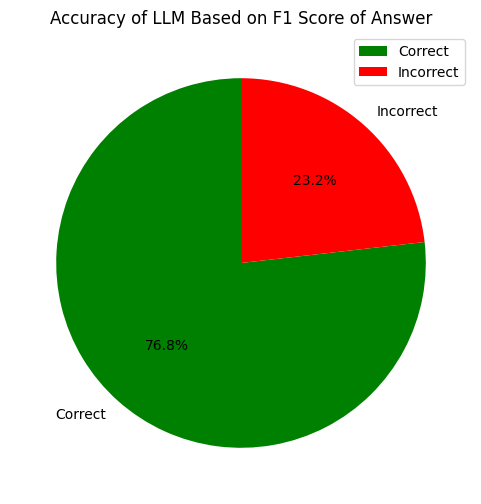

In [8]:
# Pie Chart for Answer Accuracy based on F1 Score
labels = ["Correct", "Incorrect"]
sizes = [accuracy_f1, total_questions - accuracy_f1]
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90, colors=["green", "red"])
plt.legend()
plt.title("Accuracy of LLM Based on F1 Score of Answer")
plt.show()

## 4. Bar Plot for Precision, Recall, F-measure

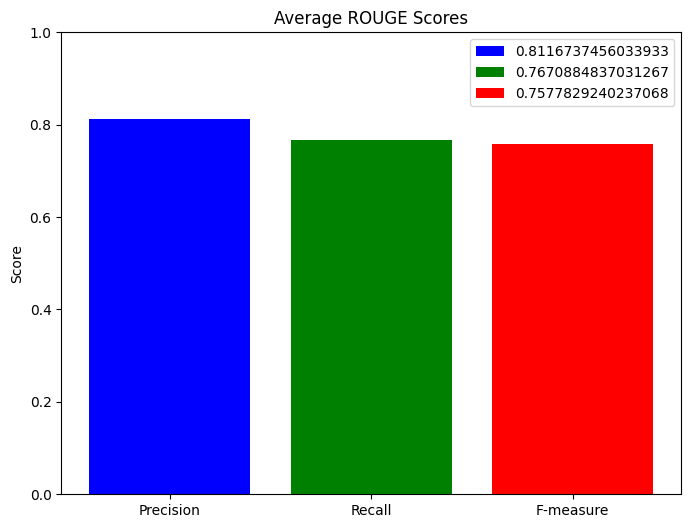

In [9]:
# 2. Bar Chart for ROUGE Scores
metrics = ["Precision", "Recall", "F-measure"]
avg_scores = [avg_precision, avg_recall, avg_fmeasure]
colors = ['blue', 'green', 'red']
plt.figure(figsize=(8, 6))
bars = plt.bar(metrics, avg_scores, color=colors)
plt.ylim(0, 1)
plt.title("Average ROUGE Scores")
plt.ylabel("Score")
plt.legend(bars, avg_scores)
plt.show()

## 5. Word Cloud for Incorrect Answers

In [10]:
# Download stopwords
nltk.download("stopwords", quiet=True)
# Get English stopwords
stop_words = set(stopwords.words("english"))
print(len(stop_words))

# Print first 10 stopwords
print(list(stop_words)[:10])

179
["mustn't", 'who', 't', 'then', 'how', 'than', 'll', 'about', 'doing', 'some']


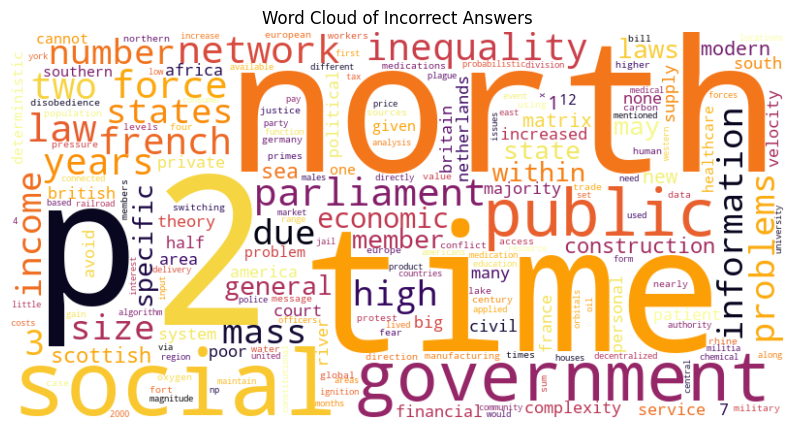

In [11]:
# Extract Incorrect Answers based on F1 Score
incorrect_answers = []
for question, data in results.items():
    if data["rouge_score"]['fmeasure'] < 0.5:
        incorrect_answers.append(data["llm_answer"])

# Tokenize and Count Words
all_words = " ".join(incorrect_answers).lower().split()
filtered_words = [word for word in all_words if word not in stop_words]
word_counts = Counter(filtered_words)

# Generate Word Cloud
wordcloud = WordCloud(
    width=800, height=400, background_color="white", colormap="inferno"
).generate_from_frequencies(word_counts)

# Display the Word Cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Incorrect Answers")
plt.show()